In [1]:
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb

import pandas as pd
import numpy as np
import pickle
import time
import shap
import os
import gc

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

import shap
shap.initjs()

from sm_utils import sampling, evaluate, save_model, load_model
from sm_utils import make_train_data,  make_test_data, df_to_md_table

In [80]:
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, average_precision_score

from bayes_opt import BayesianOptimization

## Load data

In [3]:
DATA_PATH = '/home/dmig/work/upsell/data'
MODEL_PATH = '/home/dmig/work/upsell/model'

In [4]:
RESULT_PATH = '/home/dmig/work/upsell/result/summary'

In [5]:
# df_mart01 = pd.read_pickle(os.path.join(DATA_PATH, 'df_mart_201901.pkl'))
df_mart04 = pd.read_pickle(os.path.join(DATA_PATH, 'df_mart_201904.pkl'))
df_mart05 = pd.read_pickle(os.path.join(DATA_PATH, 'df_mart_201905.pkl'))

# df_input06 = pd.read_pickle(os.path.join(DATA_PATH, 'df_input_201906.pkl'))

In [6]:
df_mart04.shape, df_mart05.shape

((18626176, 81), (18707537, 81))

In [7]:
total_feature = list(df_mart04.columns)
feature_cols = [c for c in total_feature if c not in ['svc_mgmt_num', 'label']]

## Add features

In [10]:
feature_type1 = feature_cols + ['diff_svc_scrb_avg_scrb']
feature_type2 = feature_cols + ['diff_2_svc_scrb_avg_scrb']
feature_type3 = feature_cols + ['diff_svc_scrb_avg_scrb', 'diff_2_svc_scrb_avg_scrb']

In [11]:
df_mart04['diff_svc_scrb_avg_scrb'] = df_mart04['svc_scrb_period'] - df_mart04['avg_subscription_period']
df_mart05['diff_svc_scrb_avg_scrb'] = df_mart05['svc_scrb_period'] - df_mart05['avg_subscription_period']
df_mart04['diff_2_svc_scrb_avg_scrb'] = 2*df_mart04['svc_scrb_period'] - df_mart04['avg_subscription_period']
df_mart05['diff_2_svc_scrb_avg_scrb'] = 2*df_mart05['svc_scrb_period'] - df_mart05['avg_subscription_period']

## Data 준비
- 5월로 train
- 4월로 test

In [12]:
train_result = make_train_data(df_mart05)
x_trn = train_result['trn']['x']
y_trn = train_result['trn']['y']
x_val = train_result['val']['x']
y_val = train_result['val']['y']

make_train_data +++
label/sample:  0.2
sample/total:  0.11652977086187241
make_data_for_modeling---


In [16]:
test_result = make_test_data(df_mart04.sample(frac=0.1))
x_test = test_result['x']
y_test = test_result['y']

In [14]:
lgb_trn_type1 = lgb.Dataset(x_trn[feature_type1], y_trn, feature_name=feature_type1)
lgb_val_type1 = lgb.Dataset(x_val[feature_type1], y_val, feature_name=feature_type1)

lgb_trn_type2 = lgb.Dataset(x_trn[feature_type2], y_trn, feature_name=feature_type2)
lgb_val_type2 = lgb.Dataset(x_val[feature_type2], y_val, feature_name=feature_type2)

lgb_trn_type3 = lgb.Dataset(x_trn[feature_type3], y_trn, feature_name=feature_type3)
lgb_val_type3 = lgb.Dataset(x_val[feature_type3], y_val, feature_name=feature_type3)

In [19]:
lgb_dataset = lgb_datasets[0]
params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'is_unbalance': True,
        'num_leaves': 64,
        'learning_rate': 0.05,
        'num_threads': 40,
}

In [74]:
lgb_datasets = [
    {'trn': lgb_trn_type1, 'val': lgb_val_type1, 'tst': x_test[feature_type1]},
    {'trn': lgb_trn_type2, 'val': lgb_val_type2, 'tst': x_test[feature_type2]},
    {'trn': lgb_trn_type3, 'val': lgb_val_type3, 'tst': x_test[feature_type3]}
]

In [101]:
def lgb_eval(num_leaves, feature_fraction, lambda_l1, 
             lambda_l2, feature_type, num_boost_round):
    params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'is_unbalance': True,
        'learning_rate': 0.05,
        'num_threads': 30,
    }
    
    params['num_leaves'] = int(num_leaves)
    params['feature_fraction'] = feature_fraction
    params['lambda_l1'] = lambda_l1
    params['lambda_l2'] = lambda_l2
    
    _feature_type = int(feature_type)
    lgb_dataset = lgb_datasets[_feature_type]
    
    _num_boost_round = int(num_boost_round)
    
    
    print('num_leaves: ', num_leaves)
    print('feature_fraction: ', feature_fraction)
    print('num_of_features:', lgb_dataset['tst'].shape[1])
    print('lambda_l1: ', lambda_l1)
    print('lambda_l2: ', lambda_l2)
    print('_feature_type: ',_feature_type)
    print('_num_boost_round: ',_num_boost_round)
    
    t1 = time.time()
    clf = lgb.train(params,
                    train_set=lgb_dataset['trn'],
                    valid_sets=[lgb_dataset['trn'], lgb_dataset['val']],
                    num_boost_round=_num_boost_round,
                    early_stopping_rounds=50,
                    verbose_eval=100)
    t2 = time.time()
    print('train에 걸린 시간(초): ', t2-t1)
    
    # auc value는 test data로
    print('local auc: ', clf.best_score['valid_1']['auc'])
    
    y_pred = clf.predict(lgb_dataset['tst'],num_threads=30 )
    print('prediction에 걸린 시간(초): ', time.time()-t2)
    
    test_auc = roc_auc_score(y_test.label.values, y_pred)
    print('test auc: ', test_auc)
    
    ap = average_precision_score(y_test.label.values, y_pred)
    print('ap: ', ap)
    
    return ap

In [92]:
target_params = {'num_leaves': (2, 128),
                 'feature_fraction': (0.5, 0.9),
                 'lambda_l1': (0, 100),
                 'lambda_l2': (0, 1000),
                 'feature_type': (0,2.9999),
                 'num_boost_round': (500,2000)}

In [88]:
lgbBO = BayesianOptimization(lgb_eval, target_params)

In [89]:
lgbBO.maximize(init_points=10, n_iter=100)

|   iter    |  target   | featur... | featur... | lambda_l1 | lambda_l2 | num_bo... | num_le... |
-------------------------------------------------------------------------------------------------
num_leaves:  17.52934954395078
feature_fraction:  0.5719126946227028
num_of_features: 80
lambda_l1:  89.3190399474437
lambda_l2:  640.9926266595114
_feature_type:  0
_num_boost_round:  1896
Training until validation scores don't improve for 50 rounds.
[100]	training's auc: 0.841019	valid_1's auc: 0.840605
[200]	training's auc: 0.848689	valid_1's auc: 0.848341
[300]	training's auc: 0.852357	valid_1's auc: 0.85192
[400]	training's auc: 0.85444	valid_1's auc: 0.853834
[500]	training's auc: 0.85611	valid_1's auc: 0.855333
[600]	training's auc: 0.85727	valid_1's auc: 0.856308
[700]	training's auc: 0.858357	valid_1's auc: 0.857218
[800]	training's auc: 0.859295	valid_1's auc: 0.85798
[900]	training's auc: 0.860005	valid_1's auc: 0.858521
[1000]	training's auc: 0.860655	valid_1's auc: 0.859025
[1100]

IndexError: list index out of range

In [93]:
from pandas.io.json import json_normalize

In [94]:
df_params = json_normalize(pd.DataFrame(lgbBO.res)['params'])

In [95]:
df_res = pd.concat([df_params, pd.DataFrame(lgbBO.res)['target']], axis=1)

In [ ]:
sns.

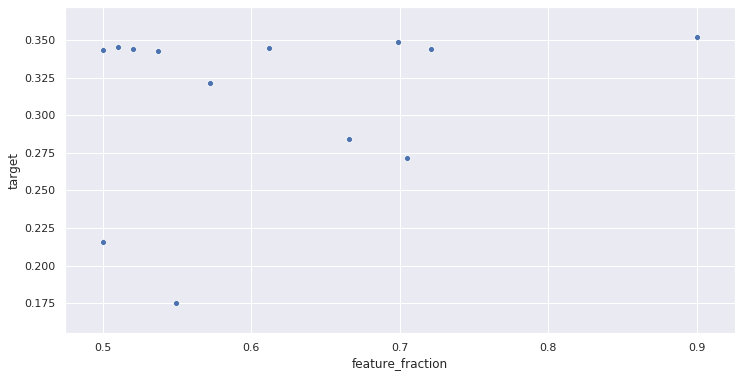

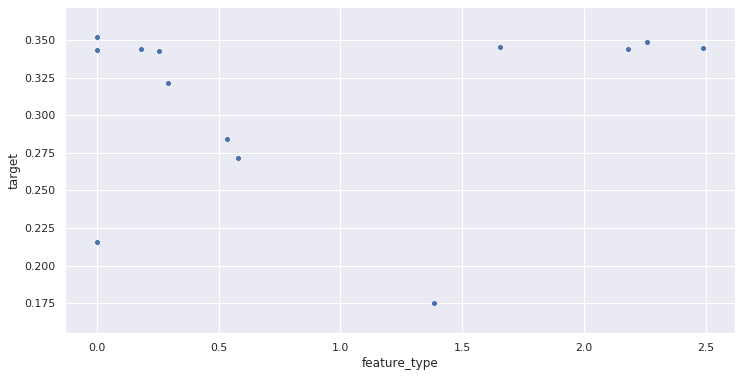

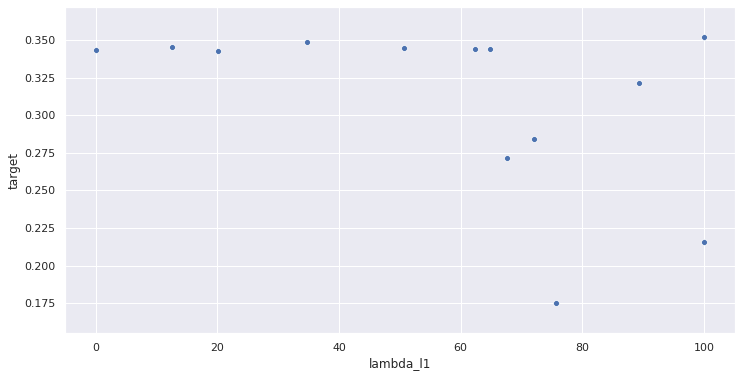

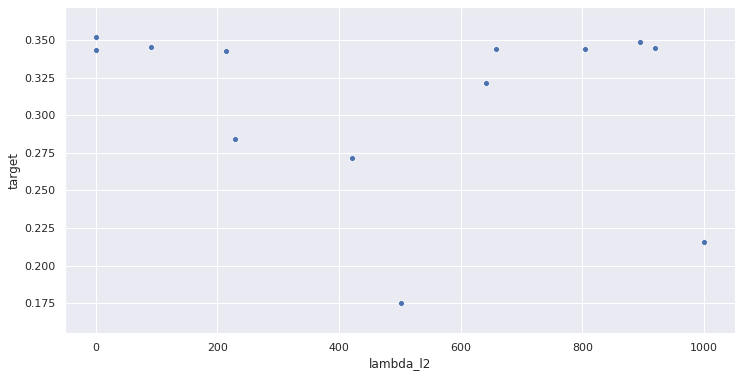

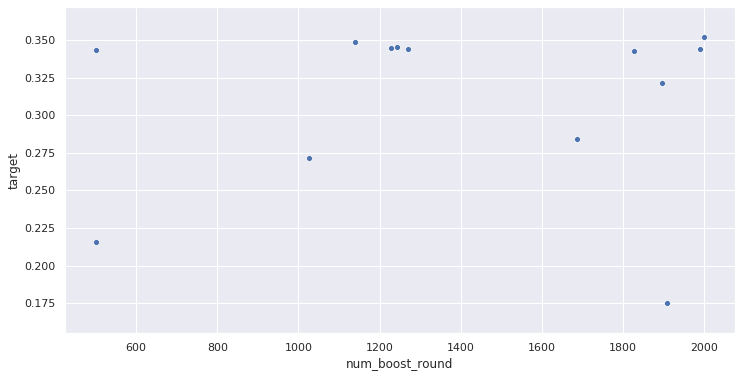

In [96]:
for col in df_params.columns:
    sns.set(rc={'figure.figsize': (12,6)})
    sns.scatterplot(df_res[col], df_res['target'])
    plt.show()

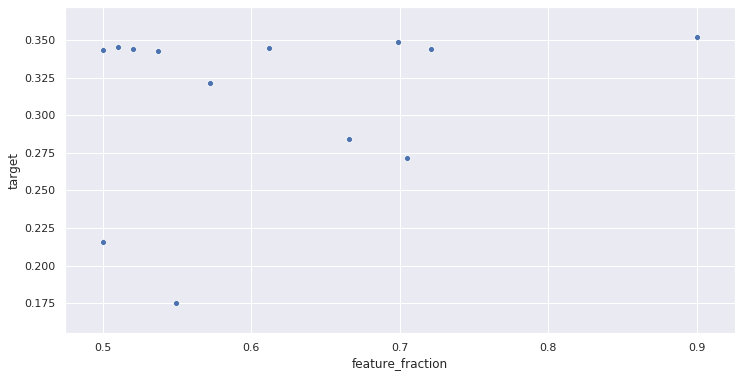

In [97]:
sns.scatterplot(df_res['feature_fraction'], df_res['target'])

In [98]:
df_res.sort_values('target', ascending=False)

feature_fraction  feature_type   lambda_l1    lambda_l2  num_boost_round  \
12          0.900000      0.000000  100.000000     0.000000      2000.000000   
4           0.698443      2.259011   34.756670   894.407829      1138.991906   
6           0.510023      1.655474   12.642196    90.737927      1243.715128   
7           0.612131      2.488449   50.700056   918.834340      1227.034378   
2           0.520366      2.182136   64.876104   658.239538      1269.582326   
9           0.721276      0.181705   62.314009   804.857254      1990.572414   
10          0.500000      0.000000    0.000000     0.000000       500.000000   
1           0.537437      0.255672   20.086577   213.672108      1827.883673   
0           0.571913      0.292701   89.319040   640.992627      1895.980732   
8           0.665914      0.535269   72.053532   228.419846      1687.021384   
5           0.704781      0.579661   67.641125   420.888822      1025.383848   
11          0.500000      0.000000  100.000000  1000.000000       500.000000   
3           0.549080      1.382590   75.727452   501.763288      1909.270484   

    num_leaves    target  
12  128.000000  0.351829  
4   109.511964  0.348471  
6   114.090651  0.345454  
7    95.597942  0.344644  
2   110.108479  0.344141  
9    61.994412  0.343666  
10  128.000000  0.343207  
1    61.316542  0.342585  
0    17.529350  0.321611  
8    65.282154  0.284411  
5    70.867386  0.271697  
11    2.000000  0.215893  
3     3.459200  0.174970

In [102]:
lgbBO = BayesianOptimization(lgb_eval, target_params)

In [103]:
lgbBO.maximize(init_points=10, n_iter=100)

|   iter    |  target   | featur... | featur... | lambda_l1 | lambda_l2 | num_bo... | num_le... |
-------------------------------------------------------------------------------------------------
num_leaves:  25.95059979084785
feature_fraction:  0.8229059773112801
num_of_features: 80
lambda_l1:  35.96476609207888
lambda_l2:  183.4880210977433
_feature_type:  1
_num_boost_round:  1949
Training until validation scores don't improve for 50 rounds.
[100]	training's auc: 0.801532	valid_1's auc: 0.800495
[200]	training's auc: 0.814133	valid_1's auc: 0.813137
[300]	training's auc: 0.820775	valid_1's auc: 0.819588
[400]	training's auc: 0.825644	valid_1's auc: 0.824211
[500]	training's auc: 0.828873	valid_1's auc: 0.827159
[600]	training's auc: 0.831369	valid_1's auc: 0.829335
[700]	training's auc: 0.833633	valid_1's auc: 0.831246
[800]	training's auc: 0.835118	valid_1's auc: 0.832406
[900]	training's auc: 0.837613	valid_1's auc: 0.834723
[1000]	training's auc: 0.842314	valid_1's auc: 0.839325


In [104]:
from pandas.io.json import json_normalize

df_params = json_normalize(pd.DataFrame(lgbBO.res)['params'])
df_res = pd.concat([df_params, pd.DataFrame(lgbBO.res)['target']], axis=1)

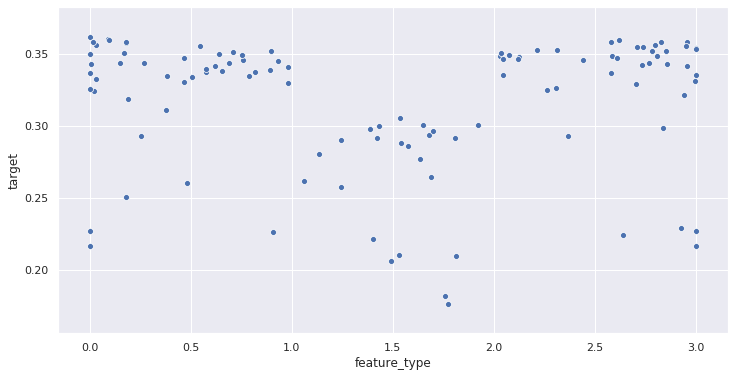

In [105]:
for col in df_params.columns:
    sns.set(rc={'figure.figsize': (12,6)})
    sns.scatterplot(df_res[col], df_res['target'])
    plt.show()

In [106]:
df_res.sort_values('target', ascending=False)

feature_fraction  feature_type   lambda_l1    lambda_l2  num_boost_round  \
40           0.900000  0.000000e+00    0.000000   855.889273      2000.000000   
20           0.880156  9.028210e-02    0.492792   637.481998      1863.755011   
102          0.695638  9.642207e-02   25.988177   641.952209      1719.026702   
74           0.595083  2.617727e+00    2.399706   327.249320      1996.565622   
94           0.674196  1.827653e-01    2.587482   419.322286      1851.057809   
96           0.681880  2.952705e+00    1.145831   945.813075      1656.201484   
16           0.741827  2.578422e+00    0.244713   783.017516      1557.043005   
57           0.593455  2.827163e+00    0.298460   630.704140      1997.658985   
77           0.807177  1.536064e-02   96.985326   219.501856      1993.941352   
52           0.745388  1.798799e-01    7.095484   999.968726      1790.759590   
78           0.684855  2.796733e+00    0.221862   803.357198      1775.527576   
73           0.849533  3.183833e-02   99.714164     4.417187      1881.532532   
105          0.727371  2.951068e+00    8.248378   641.861306      1396.506521   
88           0.551253  5.456236e-01   88.130032   504.794365      1991.958594   
54           0.715959  2.736836e+00    2.377041   588.939564      1638.633622   
93           0.872207  2.707270e+00    1.547010   784.329965      1917.343942   
28           0.900000  2.999900e+00  100.000000     0.000000      1677.365085   
32           0.900000  2.999900e+00  100.000000     0.000000      2000.000000   
48           0.731827  2.210366e+00   37.413965   999.150866      1471.864871   
67           0.772384  2.309631e+00   85.610821   729.476610      1989.518612   
43           0.643796  8.964362e-01   95.326185   633.836602      1614.206362   
63           0.762556  2.781416e+00    4.878567   619.037744      1167.990215   
44           0.801926  2.851148e+00   99.231090     1.080838      1508.850740   
62           0.864021  7.114286e-01   87.530831   179.680423      1150.451744   
106          0.702181  2.032436e+00   99.967745   830.267027      1994.365640   
37           0.793775  1.681401e-01   99.261901   651.873222      1391.405885   
103          0.725110  6.389876e-01   17.310207    77.910541      1487.675589   
25           0.500000  7.207478e-11    0.000000     0.000000      2000.000000   
76           0.558204  7.518430e-01   10.822032   171.190015      1577.776068   
15           0.501783  2.074347e+00    0.000000     0.000000      1409.820304   
..                ...           ...         ...          ...              ...   
82           0.625032  1.385411e+00   98.715846   167.402770      1605.542701   
97           0.639761  1.697677e+00    3.537504   450.107152      1046.387926   
9            0.592200  1.676670e+00   82.211710   373.964714      1731.972298   
19           0.565093  2.366328e+00   93.339266     4.123062      1268.040108   
109          0.630984  2.525999e-01   99.457451   831.766538       753.611384   
22           0.614647  1.421272e+00    0.391156   983.646554      1052.985247   
4            0.806893  1.808094e+00   93.153448   909.036261      1813.261544   
3            0.845838  1.244383e+00   59.058189   414.309933      1968.270805   
66           0.540676  1.541562e+00   94.536744   985.118903      1646.001933   
69           0.650140  1.572640e+00   96.978660   460.572799      1255.230502   
21           0.799631  1.134270e+00    4.355462   738.227722       594.455363   
55           0.857161  1.635780e+00    2.305011   988.202415       698.049030   
24           0.615175  1.686408e+00   99.241616   171.265090       731.118227   
0            0.822906  1.060703e+00   35.964766   183.488021      1949.472094   
45           0.511761  4.837404e-01   97.989062   663.281078      1469.247674   
85           0.551069  1.241979e+00   91.451456   358.783256       511.950290   
60           0.842902  1.809342e-01   85.972775   995.474171       965.674119   
14           0.900000  2.925403e+00 